Seja o sistema $y(s) = G(s)u(s)$, com $G(s)=\frac{1}{\tau s + 1}$. Arrumando temos:
$\tau y s + y = u$. Transformando para o domínio do tempo: $\tau \dot{y} = - y + u$, ou seja, $\dot{y}=\frac{-y+u}{\tau}$

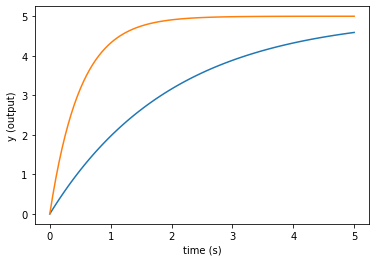

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def dydt(y, time, u, tau): #yponto
    return (-y + u)/tau

time = np.linspace(0, 5, 100) #T = 5/100 = 0.05 s ou 50 ms
y0 = 0
y1 = odeint(dydt, y0=y0, t=time, args=(5,2)) # u, tau
y2 = odeint(dydt, y0=y0, t=time, args=(5,0.5))

plt.plot(time, y1, time, y2)
plt.xlabel('time (s)')
plt.ylabel('y (output)')
plt.show()

Sistema de segunda ordem - massa/mola

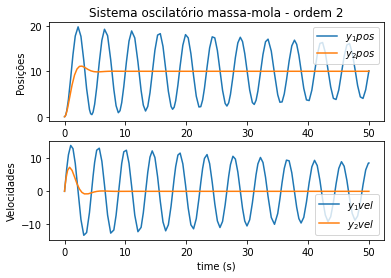

Wall time: 805 ms


In [4]:
%%time
"""
Seja massa m = 0.5 kg
     constante da mola k = 1 N/cm
     coeficiente de amortecimento b = 0.01 N.s/cm
     y/u = 1 / (ms^2+bs+k)
     Por Prof. Josenalde Oliveira - Sistemas Embarcados TADS UFRNt
"""
def massaMola(time,X,m,k,b,u):
    #m = 0.5
    #k = 1
    #b = 0.01 # testar com 0.3 e com 1
    x1,x2 = X
    dotx1 = x2
    dotx2 = (1/m)*(-k*x1-b*x2+u) # u = força externa / sinal de controle
    return dotx1, dotx2

ti = 0
tf = 50
x10,x20=0,0 #assume que a mola esta em repouso x = 0, v = 0

# método de solução de ode Runge-Kutta implícito de ordem 5 RADAU
from scipy import integrate
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
sol1 = integrate.solve_ivp(massaMola, t_span=(ti, tf), y0=(x10, x20), method='Radau', args=(0.5,1.,0.01,10))
sol2 = integrate.solve_ivp(massaMola, t_span=(ti, tf), y0=(x10, x20), method='Radau', args=(0.5,1.,0.8,10))
t1, Y1 = sol1.t, sol1.y
t2, Y2 = sol2.t, sol2.y

# Separando as soluções y1 é y, y2 é dot_y
y1_pos, y1_vel = Y1 # y1 posicao, y2 velocidade
y2_pos, y2_vel = Y2 # y1 posicao, y2 velocidade

plt.figure(1)
plt.subplot(211)
plt.plot(t1, y1_pos, label=r'$y_1pos$')
plt.plot(t2, y2_pos, label=r'$y_2pos$')
plt.legend()
plt.xlabel('time (s)')
plt.title('Sistema oscilatório massa-mola - ordem 2')
plt.ylabel('Posições')
plt.subplot(212)
plt.plot(t1, y1_vel, label=r'$y_1vel$')
plt.plot(t2, y2_vel, label=r'$y_2vel$')

plt.legend()
plt.xlabel('time (s)')
plt.ylabel('Velocidades')
plt.show()



Raízes de polinômios com <code>numpy</code>. Vetor com os coeficientes para o método roots

In [2]:
import numpy as np
d1 = [0.5, 0.01, 1]
print(np.roots(d1))
d2 = [0.5, 0.3, 1]
print(np.roots(d2))
d3 = [1, 0.4255, 3.1289]
print(np.roots(d3))

[-0.01+1.41417821j -0.01-1.41417821j]
[-0.3+1.3820275j -0.3-1.3820275j]
[-0.21275+1.75602888j -0.21275-1.75602888j]


O Sistema com denominador d1 possui raízes mais próximas do eixo imaginário, portanto, mais oscilatório

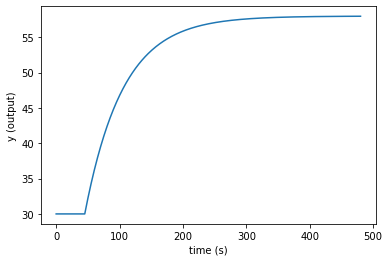

In [19]:

######################################################
# FOPDT model                                        #
######################################################
Kp = 0.4      # degC/%
tauP = 60.0  # seconds
thetaP = 15   # seconds (integer)
Tss = 30      # degC (ambient temperature)
Qss = 0       # % heater
dt = 1 #1s
Tpl = []
Tpl.append(30)
i = 1
tMax = 8*60
nSamples = tMax/dt
# Simulate one time step with linear FOPDT model
z = np.exp(-dt/tauP)
Q1 = np.ones(int(nSamples)) * 0
Q1[30:] = 70.0
while (i <= nSamples):
    Tpl.append((Tpl[i-1]-Tss) * z + (Q1[max(0, i-int(thetaP)-1)]-Qss)*(1-z)*Kp + Tss)      
    i += 1

time = np.linspace(0, tMax, int(nSamples))
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(time, Tpl[0:480])
plt.xlabel('time (s)')
plt.ylabel('y (output)')
plt.show()    